In [2]:
import pandas as pd 
from datetime import datetime

In [3]:
df_data = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Данные')
df_clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Clients')
df_region = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')

In [4]:
df_data = df_data.dropna()
df_clients = df_clients.dropna()

In [5]:
df_region_gb = df_region.groupby('city')['id_trading_point'].count().reset_index()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

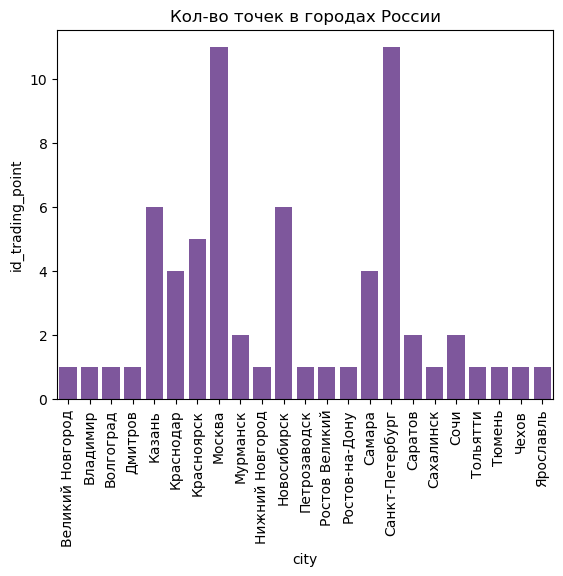

In [37]:
sns.barplot(x=df_region_gb['city'], y = df_region_gb['id_trading_point'], color='indigo', alpha = 0.7)
plt.xticks(rotation=90)
plt.title('Кол-во точек в городах России')
plt.savefig('количество точек.png')
plt.show()

In [8]:
df_data_gb = df_data.groupby('id_client')['amt_payment'].sum().reset_index()

In [9]:
merged_df = pd.merge(df_data_gb, df_clients, on='id_client', how='right')

In [10]:
merged_df.fillna(0, inplace=True)

In [11]:
merged_df =pd.merge(merged_df, df_region, on ='id_trading_point', how='inner')

In [12]:
def flag (value):
    if value > 0:
        return 1
    else:
        return 0
merged_df['payment_flag'] = merged_df['amt_payment'].apply(flag)

In [13]:
from scipy import stats
def test_calc (r1, r2, alpha=0.05):
    t_stat, p_value = stats.ttest_ind(r1, r2) 
    if p_value < alpha:
        print(f"Разница есть, p-value = {p_value}")
    else:
        print(f"Нет разницы, p-value = {p_value}")
    return t_stat, p_value

In [14]:
from scipy.stats import mannwhitneyu
def mann_whitney_func (r1, r2, alpha=0.05):
    U, p = mannwhitneyu(r1, r2)
    if p < alpha:
        print(f"Разница есть, p-value = {p}")
    else:
        print(f"Нет разницы, p-value = {p}")
    return U, p

In [15]:
merged_df.head()

,id_client,amt_payment,dtime_ad,nflag_test,id_trading_point,city,payment_flag
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск,1
1,223863.0,0.0,2022-08-20 21:56:54.325,0,212,Красноярск,0
2,201715.0,4171.0,2022-07-30 19:07:49.264,1,212,Красноярск,1
3,292010.0,0.0,2022-07-26 20:37:16.885,1,212,Красноярск,0
4,190438.0,6026.0,2022-07-02 12:53:04.753,1,212,Красноярск,1


In [16]:
error_points = []
for i in merged_df['id_trading_point'].unique():
    df_cycle = merged_df[merged_df['id_trading_point'] == i]
    df_control = df_cycle[df_cycle['nflag_test']==0]
    df_test = df_cycle[df_cycle['nflag_test']==1]
    if df_test['amt_payment'].sum()==0 or df_test['nflag_test'].empty or df_test['id_client'].count()==0:
        error_points.append(i) 
    elif df_control['amt_payment'].sum()==0 or df_control['nflag_test'].empty or df_control['id_client'].count()==0:
        error_points.append(i) 
print(error_points)

[1015, 866, 1099, 739, 46, 228, 26, 603, 810, 800, 7, 23, 4, 1, 13]


In [17]:
filtered_data = pd.DataFrame()
filtered_data = merged_df[~ merged_df['id_trading_point'].isin(error_points)]

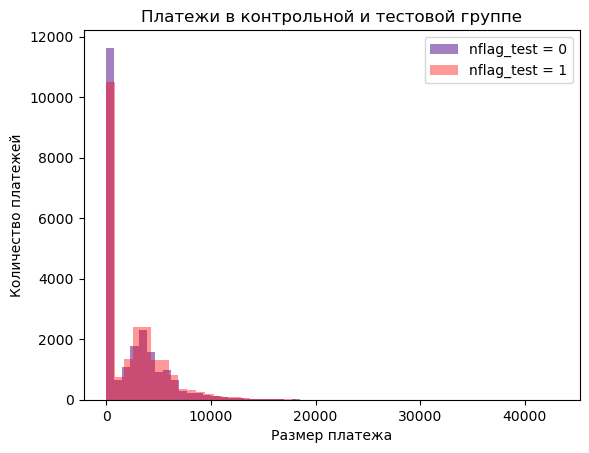

In [18]:
nflag_0 = filtered_data[filtered_data['nflag_test'] == 0]['amt_payment']
nflag_1 = filtered_data[filtered_data['nflag_test'] == 1]['amt_payment']


plt.hist(nflag_0, alpha=0.5, label='nflag_test = 0', bins=50, color = 'indigo')
plt.hist(nflag_1, alpha=0.4, label='nflag_test = 1', bins=50, color = 'red')

plt.xlabel('Размер платежа')
plt.ylabel('Количество платежей')
plt.legend(loc='upper right')
plt.title('Платежи в контрольной и тестовой группе')
plt.show()

In [19]:
test = filtered_data[filtered_data['nflag_test'] == 1]
control = filtered_data[filtered_data['nflag_test'] == 0]

test_calc(test['amt_payment'], control['amt_payment'])
test_calc(test['payment_flag'], control['payment_flag'])

Разница есть, p-value = 3.3214645838934018e-21
Разница есть, p-value = 1.7338073027564523e-20


(9.282032730948323, 1.7338073027564523e-20)

In [20]:
mann_whitney_func(test['amt_payment'], control['amt_payment'])

Разница есть, p-value = 3.008345273971901e-24


(270040116.0, 3.008345273971901e-24)

In [21]:
test_Moscow = filtered_data[(filtered_data['nflag_test'] == 1) & (filtered_data['city'] == 'Москва')]
control_Moscow = filtered_data[(filtered_data['nflag_test']) == 0 & (filtered_data['city'] == 'Москва')]

In [22]:
test_calc(test_Moscow['amt_payment'], control_Moscow['amt_payment'])
test_calc(test_Moscow['payment_flag'], control_Moscow['payment_flag'])
mann_whitney_func(test_Moscow['amt_payment'], control_Moscow['amt_payment'])

Разница есть, p-value = 1.6739802095103576e-05
Разница есть, p-value = 1.1246141554750896e-09
Разница есть, p-value = 6.326271057960635e-10


(73531999.5, 6.326271057960635e-10)

In [23]:
test_SPB = filtered_data[(filtered_data['nflag_test'] == 1) & (filtered_data['city'] == 'Санкт-Петербург')]
control_SPB = filtered_data[(filtered_data['nflag_test']) == 0 & (filtered_data['city'] == 'Санкт-Петербург')]

In [24]:
test_calc(test_SPB['amt_payment'], control_SPB['amt_payment'])
test_calc(test_SPB['payment_flag'], control_SPB['payment_flag'])
mann_whitney_func(test_SPB['amt_payment'], control_SPB['amt_payment'])

Разница есть, p-value = 4.949391989830004e-07
Разница есть, p-value = 7.376698522668691e-09
Разница есть, p-value = 2.3932393406677435e-09


(53529750.5, 2.3932393406677435e-09)

In [25]:
filtered_data.head()

,id_client,amt_payment,dtime_ad,nflag_test,id_trading_point,city,payment_flag
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск,1
1,223863.0,0.0,2022-08-20 21:56:54.325,0,212,Красноярск,0
2,201715.0,4171.0,2022-07-30 19:07:49.264,1,212,Красноярск,1
3,292010.0,0.0,2022-07-26 20:37:16.885,1,212,Красноярск,0
4,190438.0,6026.0,2022-07-02 12:53:04.753,1,212,Красноярск,1


In [26]:
import numpy as np
final_df = pd.DataFrame(columns=['city', 'id_trading_point', 'count_test', 'count_control', 'count_all',
                                 'percent_count', 'avg_payment_test',
                                 'avg_payment_control', 'diff', 'sigma_test', 'sigma_control', 'ttest',
                                 'pvalue_ttest'])
test = pd.DataFrame
control = pd.DataFrame
for i in filtered_data['city'].unique():

    for j in filtered_data[filtered_data['city']==i]['id_trading_point'].unique():
        
        test = filtered_data[(filtered_data['nflag_test'] == 1) & (filtered_data['city'] == i) & (filtered_data['id_trading_point'] == j)]
        control = filtered_data[(filtered_data['nflag_test'] == 0) & (filtered_data['city'] == i) & (filtered_data['id_trading_point'] == j)]
        
        count_test = len(test)
        count_control = len(control)     
        count_all = count_test + count_control                            
        percent_count = count_all/len(filtered_data)*100
        
        avg_payment_test = np.mean(test['amt_payment'])
        avg_payment_control = np.mean(control['amt_payment'])
        diff = avg_payment_test - avg_payment_control
                                       
        sigma_test = test['amt_payment'].std()
        sigma_control = control['amt_payment'].std()
                                          
                                        
        t_stat, p_value = test_calc(test['amt_payment'], control['amt_payment'])
        test_calc_payment_flag = test_calc(test['payment_flag'], control['payment_flag'])
        mann_whitney_result = mann_whitney_func(test['amt_payment'], control['amt_payment'])
        
        final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test, 
                                   'count_control':count_control, 'count_all':count_all,
                                   'percent_count':percent_count,
                                   'avg_payment_test':avg_payment_test , 'avg_payment_control':avg_payment_control,
                                    'diff':diff, 'sigma_test':sigma_test,
                                    'sigma_control':sigma_control, 'ttest': t_stat, 'pvalue_ttest':p_value}, ignore_index = True)

Нет разницы, p-value = 0.6287709476405416
Нет разницы, p-value = 0.6520917611862189
Нет разницы, p-value = 0.8468854097705489
Нет разницы, p-value = 0.06901056074583502
Нет разницы, p-value = 0.4108986349888111
Нет разницы, p-value = 0.1782203706588702
Нет разницы, p-value = 0.24830826390447136
Нет разницы, p-value = 0.5318451364327887
Нет разницы, p-value = 0.41423301365101106
Нет разницы, p-value = 0.3808017001028424
Нет разницы, p-value = 0.45446298978722766
Нет разницы, p-value = 0.27663524008058304
Нет разницы, p-value = 0.3264127897793312
Нет разницы, p-value = 0.7308242264735305
Нет разницы, p-value = 0.5059942188118851
Нет разницы, p-value = 0.922300518333421
Нет разницы, p-value = 0.8763728757160062
Нет разницы, p-value = 0.71170696573546
Нет разницы, p-value = 0.9910124894120407
Нет разницы, p-value = 0.25813263417741805
Нет разницы, p-value = 0.6923131354325986
Разница есть, p-value = 0.024501004890271766
Нет разницы, p-value = 0.20807190183768315
Нет разницы, p-value = 0.06

C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be 

Разница есть, p-value = 6.983206901274464e-07
Разница есть, p-value = 3.381305634110329e-08
Разница есть, p-value = 1.8091938713109172e-07
Нет разницы, p-value = 0.07683710303752554
Разница есть, p-value = 0.0281319517757112
Разница есть, p-value = 0.045325599351465
Нет разницы, p-value = 0.40375884675107376
Нет разницы, p-value = 0.35859732480203443
Нет разницы, p-value = 0.37572280719938844
Разница есть, p-value = 0.036305006065519056
Разница есть, p-value = 0.013687045550764327
Разница есть, p-value = 0.007084847385569256
Разница есть, p-value = 7.29407411923071e-05
Разница есть, p-value = 1.5777860976446114e-06
Разница есть, p-value = 1.118283984670729e-05
Нет разницы, p-value = 0.07628783375813585
Нет разницы, p-value = 0.12494525748933281
Нет разницы, p-value = 0.11361886482311798
Нет разницы, p-value = 0.21988338416718506
Нет разницы, p-value = 0.16995475575275096
Нет разницы, p-value = 0.18329299970019064
Разница есть, p-value = 0.00024525342392273575
Разница есть, p-value = 0.

C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be 

Нет разницы, p-value = 0.26876674637353626
Разница есть, p-value = 3.876566044301065e-05
Разница есть, p-value = 2.228627459614884e-07
Разница есть, p-value = 4.0465671202282305e-07
Нет разницы, p-value = 0.7780070273603263
Нет разницы, p-value = 0.6349509140686425
Нет разницы, p-value = 0.782720760814107
Нет разницы, p-value = 0.8663043555057068
Нет разницы, p-value = 0.20002209981015495
Нет разницы, p-value = 0.34992175029286443
Нет разницы, p-value = 0.7119719350975426
Нет разницы, p-value = 0.24176615429820064
Нет разницы, p-value = 0.5415888161602205
Разница есть, p-value = 6.050970845492351e-05
Нет разницы, p-value = 0.3172991169695652
Разница есть, p-value = 2.8890092060520188e-06
Нет разницы, p-value = 0.716046384232031
Нет разницы, p-value = 0.46117013807380636
Нет разницы, p-value = 0.8637165123146039
Разница есть, p-value = 0.034929468998951815
Разница есть, p-value = 0.006353519667404301
Разница есть, p-value = 0.026157259000973803
Нет разницы, p-value = 0.7815857297661141


C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be 

Нет разницы, p-value = 0.3550227648604757
Разница есть, p-value = 0.01451825932213329
Разница есть, p-value = 0.038066216007540725
Разница есть, p-value = 0.03686899928098654
Нет разницы, p-value = 0.10498894497258296
Разница есть, p-value = 0.03323940159324537
Нет разницы, p-value = 0.3467675852041211
Нет разницы, p-value = 0.14742298004096138
Нет разницы, p-value = 0.1554337208120999
Нет разницы, p-value = 0.13559014690618432
Нет разницы, p-value = 0.13794533700947484
Нет разницы, p-value = 0.18342811005486814
Разница есть, p-value = 0.010095112170351712
Нет разницы, p-value = 0.08481593543159477
Разница есть, p-value = 0.03166761411886426
Разница есть, p-value = 7.222518974571453e-20
Разница есть, p-value = 7.087699806064145e-21
Разница есть, p-value = 3.4663490572144646e-18
Разница есть, p-value = 1.1327785130388307e-07
Разница есть, p-value = 5.365610191553457e-10
Разница есть, p-value = 1.4503145247971591e-08
Разница есть, p-value = 2.1646756758588107e-06
Разница есть, p-value = 

C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append({'city':i, 'id_trading_point': j, 'count_test':count_test,
C:\Users\bobri\AppData\Local\Temp\ipykernel_13000\3478512864.py:32: FutureWarning: The frame.append method is deprecated and will be 

In [27]:
final_df['flag_result'] = np.where((final_df['pvalue_ttest'] < 0.05) & (final_df['diff'] > 0), 'Positive', np.where((final_df['pvalue_ttest'] < 0.05) & (final_df['diff'] < 0), 'Negative', 'Neutral'))

In [28]:
final_df

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,flag_result
0,Красноярск,212,593,575,1168,2.577342,2144.317032,2222.052174,-77.735142,2708.588724,2785.116250,-0.483585,6.287709e-01,Neutral
1,Красноярск,278,535,489,1024,2.259588,2499.345794,2185.214724,314.131070,2915.995329,2574.915597,1.820268,6.901056e-02,Neutral
2,Красноярск,202,551,565,1116,2.462598,2927.341198,2730.378761,196.962437,2956.686241,2737.885785,1.155073,2.483083e-01,Neutral
3,Красноярск,444,650,562,1212,2.674434,2404.106154,2545.734875,-141.628722,2810.828487,2797.138764,-0.876740,3.808017e-01,Neutral
4,Красноярск,277,708,709,1417,3.126793,2285.750000,2431.365303,-145.615303,2712.677878,2868.587569,-0.981705,3.264128e-01,Neutral
5,Мурманск,54,633,640,1273,2.809038,1702.714060,1688.512500,14.201560,2565.132440,2628.012490,0.097556,9.223005e-01,Neutral
6,Мурманск,55,422,425,847,1.869015,2109.106635,2111.272941,-2.166306,2790.993385,2804.223188,-0.011268,9.910125e-01,Neutral
7,Казань,991,270,294,564,1.244539,3249.281481,2452.986395,796.295087,4719.592601,3633.935858,2.255258,2.450100e-02,Positive
8,Казань,699,482,494,976,2.153670,2422.286307,2574.352227,-152.065920,3906.817897,4082.851356,-0.594254,5.524804e-01,Neutral
9,Казань,477,382,386,768,1.694691,2259.623037,2496.987047,-237.364010,3482.846094,3881.994719,-0.891593,3.728909e-01,Neutral


In [29]:
excel_writer = pd.ExcelWriter('тест.xlsx')

final_df[final_df['flag_result'] == 'Positive'].to_excel(excel_writer, sheet_name='Успешные группы', index=False)

final_df[final_df['flag_result'] == 'Negative'].to_excel(excel_writer, sheet_name='Неуспешные группы', index=False)

final_df[final_df['flag_result'] == 'Neutral'].to_excel(excel_writer, sheet_name='Нет разницы', index=False)

excel_writer.close()

Прибыль от успешных тестов значительно превышает убыток от неудачных. Предварительные результаты теста указывают на то, что воздействие Б имело лучший исход, чем воздействие А. Однако в этом тесте было много точек, в которых результат теста был нейтральным. Поэтому я бы предложила воспользоваться калькулятором, провести нужное количество наблюдений во всех точках и сравнить результаты теста еще раз.